In [2]:
import pandas as pd
from pathlib import Path
from src.config import lesion_level_labels_csv, dmtr_csv


save_folder = Path('/mnt/c/Users/user/data/results_dl_dcb2')
results = pd.read_csv(save_folder / 'predictions.csv').set_index('patient')
dmtr = pd.read_csv(dmtr_csv).set_index('id')
dmtr = dmtr[dmtr.center != 'avl']
lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')
flow = pd.read_csv('/mnt/c/Users/user/data/tables/patient_flow.csv', sep=';').set_index('id').replace({'yes':True,'no':False,float('nan'):False})
clinical_predictors = pd.read_csv('/mnt/c/Users/user/data/tables/clinical_predictors.csv').set_index('id')

flow = flow.loc[dmtr.index]
flow = flow.join(~dmtr['dcb'].isna())

/tmp/ipykernel_8446/2394559278.py:8: DtypeWarning: Columns (1,27,29,175,229,234,249,259,275,281,313,318,351,386,393,440,488,496,538,547,550,579,581,582,583,584,585,587,588,589,599,600,602,603,604,605,610,781,785,786,809,813,814,816,817,820,821,824,906,907,909,910,911,913,916,940,941,943,944,945,952,953,955,956,957,958,959,961,962,963,964,965,967,968,969,970,971,973,974,975,976,989,990,992,993,994,995,996,998,999,1000,1001,1002,1004,1005,1006,1007,1008,1010,1011,1012,1016,1026,1030,1033,1045,1048) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv).set_index('id')


In [3]:
print('Eligible = ', len(flow))
with_data = flow[flow.data]
print(f'Data available = {len(with_data)} (excluded {len(flow) - len(with_data)})' )
with_ce = with_data[with_data.ce]
print(f'Contrast-enhanced = {len(with_ce)} (excluded {len(with_data) - len(with_ce)})' )
with_lesion = with_ce[with_ce['target lesion']]
print(f'Target lesions = {len(with_lesion)} (excluded {len(with_ce) - len(with_lesion)})' )
with_outcome = with_lesion[with_lesion.dcb]
print(f'Outcome known = {len(with_outcome)} (excluded {len(with_lesion) - len(with_outcome)})' )


Eligible =  1347
Data available = 1228 (excluded 119)
Contrast-enhanced = 830 (excluded 398)
Target lesions = 748 (excluded 82)
Outcome known = 728 (excluded 20)


In [4]:
from tableone import TableOne
from lifelines import KaplanMeierFitter

table1data = dmtr.copy()
table1data["fu_OS"] = table1data["fu_OS"].apply(
    lambda x: int(x.split()[0]) if type(x) == str else float("nan")
)
table1data["fu_PFS"] = table1data["fu_PFS"].apply(
    lambda x: int(x.split()[0]) if type(x) == str else float("nan")
)
stage = []
for ix, row in table1data.iterrows():
    if row.Stage == "M1d":
        if row.hersenmet == 1:
            stage.append("M1d_symptomatic")
        else:
            stage.append("M1d_asymptomatic")
    elif pd.isna(row.Stage):
        stage.append("missing")
    else:
        stage.append(row.Stage)

table1data["ajcc_stage"] = stage

table1data["ldh"] = (
    (table1data.labldh + (table1data.labldhw > 500).astype(int))
    .replace({0: "missing", 1: "normal", 2: "elevated", 3: ">2x ULN", 9: "missing"})
    .fillna("missing")
)

table1data["who"] = table1data.WHO.replace([2, 3, 4], "2-4").replace(
    {0: "0", 1: "1", float("nan"): "missing"}
)

table1data["brain_metastasis"] = (
    pd.DataFrame(
        [
            table1data.locafmethersen.replace(9, float("nan")),
            table1data.hersenmet.replace(9, float("nan")) + 1,
        ]
    )
    .transpose()
    .max(axis=1)
)
table1data["brain_metastasis"] = table1data["brain_metastasis"].replace(
    {0: "absent", 1: "asymptomatic", 2: "symptomatic", float("nan"): "missing"}
)

table1data["locafmetlever"] = table1data.locafmetlever.replace(
    {0: "absent", 1: "present", 9: float("nan")}
)

affected_organs = table1data[
    [col for col in table1data.columns if col.startswith("locafmet")]
]
affected_organs = affected_organs.replace(9, float("nan"))
affected_organs["locafmethersen"] = affected_organs.locafmethersen.fillna(0)
table1data["no_affected_organs"] = (
    affected_organs.sum(axis=1, skipna=False) > 2
).astype(int)
table1data["no_affected_organs"] = table1data["no_affected_organs"].replace(
    {0: "<3", 1: ">2"}
)

table1data = table1data.rename(columns={
    'who':'ECOG performance status',
    'brain_metastasis':'Brain metastases',
    'locafmetlever':'Liver metastases',
    'ldh':'LDH',
    'no_affected_organs':'Number of affected organs',
    'dcb':'Clinical benefit',
    'response':'Objective response'
})
table1data = table1data.replace({
    'Clinical benefit':{0:'no benefit', 1:'benefit'},
    'Objective response':{0:'no response', 1:'response'},
    'LDH':{'elevated':'1-2x ULN'},
})

table1data[['Stage','Liver metastases']] = table1data[['Stage','Liver metastases']].fillna('missing')

bors = []
for _, row in table1data.iterrows():
    if row['Best overall response'] == 'Stable disease' and row['Objective response'] == 'response':
        bors.append('Partial response')
    elif row['Best overall response'] == 'Death' and row['Objective response'] == 'response':
        bors.append('Partial response')
    elif row['Best overall response'] == 'Lost to follow up':
        bors.append('Progressive disease')
    elif pd.isna(row['Best overall response']):
        if row['Objective response'] == 'response':
            bors.append('Partial response')
        else:
            if row['Clinical benefit'] == 'benefit':
                bors.append('Stable disease')
            else:
                bors.append('Progressive disease')
    else:
        bors.append(row['Best overall response'])

table1data['Best overall response'] = bors

table1data['Included'] = [ix in with_outcome.index for ix in table1data.index]
table1data['Included'] = table1data.Included.replace({True:'Included', False:'Excluded'})

subset = table1data[table1data.Included == 'Included']

TableOne(
    subset,
    columns=[
        'Age',
        'Sex',
        # 'Therapy',
        'Stage',
        'ECOG performance status',
        'Brain metastases',
        'Liver metastases',
        'LDH',
        'Number of affected organs',
        'Best overall response',
        'Clinical benefit',
        'Objective response'
    ],
    order = {
        'Brain metastases':['absent','asymptomatic','symptomatic','missing'],
        'LDH':['normal','1-2x ULN','>2x ULN'],
        'Objective response':['response','no response'],
        'Best overall response':['Complete response','Partial response','Stable disease','Progressive disease','Death'],
        'Liver meatastasis':['absent','present','missing']
    },
    groupby='center',
    nonnormal=['Age']
).to_csv('/home/rens/repos/premium_dl_ct/tables/table1.csv')

# kmf = KaplanMeierFitter()

# os_subset = subset[['fu_OS','event_OS']].dropna()
# kmf.fit(os_subset['fu_OS'], os_subset['event_OS'])
# print('Median OS (months): ', kmf.median_survival_time_ / 365 * 12)

# pfs_subset = subset[['fu_PFS','event_PFS']].dropna()
# kmf.fit(pfs_subset['fu_PFS'], pfs_subset['event_PFS'])
# print('Median PFS (months): ', kmf.median_survival_time_ / 365 * 12)
    

/tmp/ipykernel_8446/1256550773.py:59: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  affected_organs.sum(axis=1, skipna=False) > 2
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/tableone/tableone.py:1433: UserWarning: Order variable not found: Liver meatastasis
  warnings.warn("Order variable not found: {}".format(k))


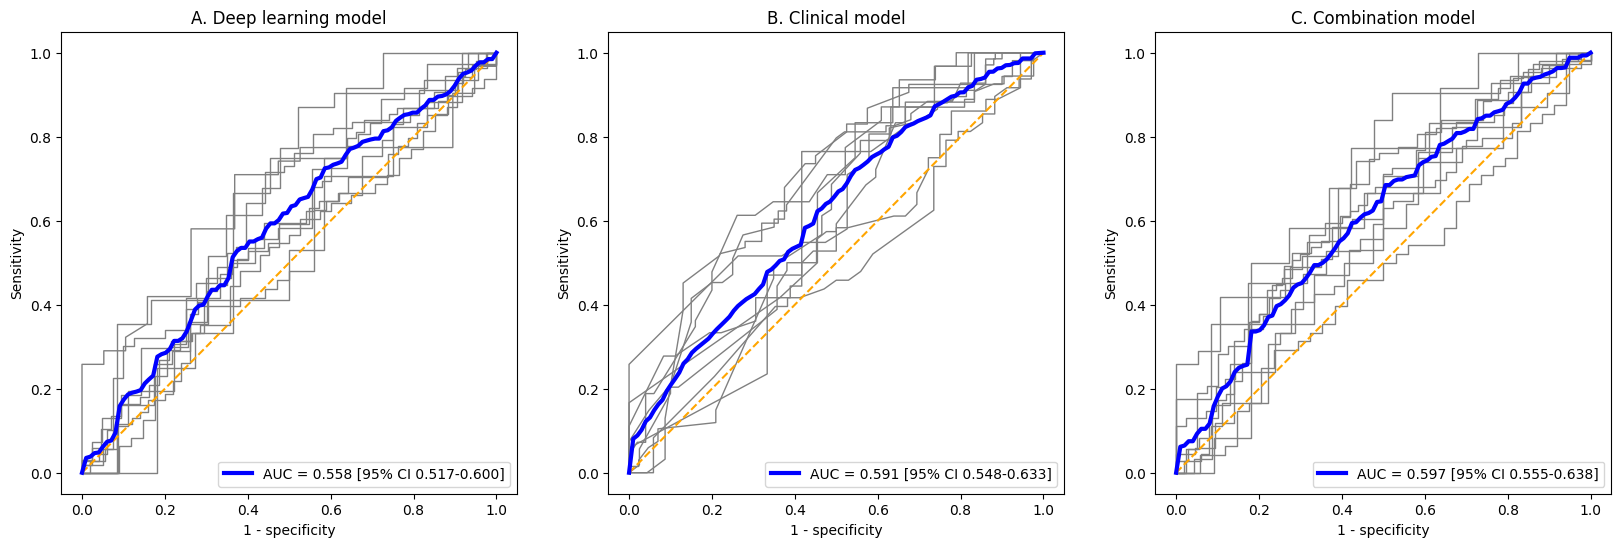

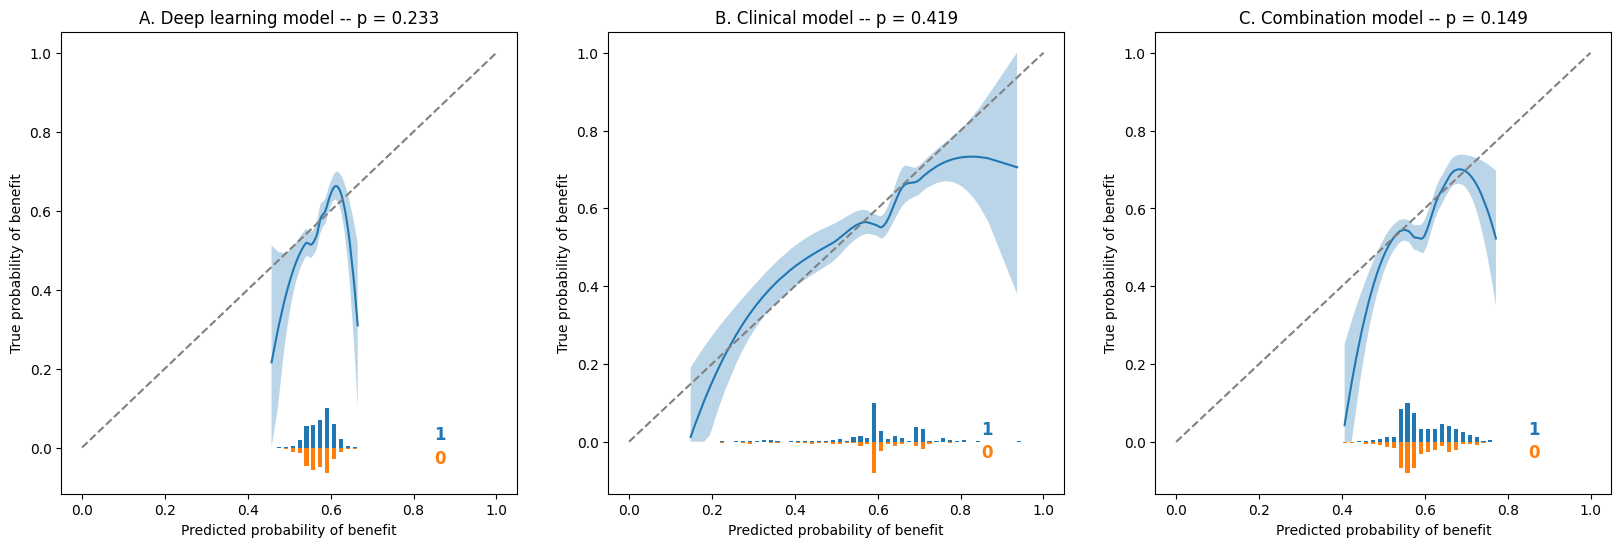

In [5]:
import matplotlib.pyplot as plt
from src.plot_utils import plot_roc, plot_calibration_curve

aucs = pd.read_csv('/home/rens/repos/premium_dl_ct/tables/auc.csv').set_index('Unnamed: 0')
target = 'dcb'

results = results[~results[target].isna()]

fig, ax = plt.subplots(1,3, figsize=(20,6))
# deep learning model
aggregated_auc = (
    aucs.loc['cvAUC', 'calibrated_dl_preds'],
    aucs.loc['ci_lower', 'calibrated_dl_preds'],
    aucs.loc['ci_upper', 'calibrated_dl_preds'],
)
plot_roc('calibrated_dl_preds',target,results, ax[0], aggregated_auc)
ax[0].set_title('A. Deep learning model')
# clinical model
aggregated_auc = (
    aucs.loc['cvAUC', 'clinical_preds'],
    aucs.loc['ci_lower', 'clinical_preds'],
    aucs.loc['ci_upper', 'clinical_preds'],
)
plot_roc('clinical_preds',target,results, ax[1], aggregated_auc)
ax[1].set_title('B. Clinical model')
# combination model
aggregated_auc = (
    aucs.loc['cvAUC', 'combination_preds'],
    aucs.loc['ci_lower', 'combination_preds'],
    aucs.loc['ci_upper', 'combination_preds'],
)
plot_roc('combination_preds',target,results, ax[2], aggregated_auc)
ax[2].set_title('C. Combination model')
fig.show()

fig, ax = plt.subplots(1,3, figsize=(20,6))
# deep learning model
plot_calibration_curve('calibrated_dl_preds',target,results, ax[0])
p = aucs.loc['hoslem','calibrated_dl_preds']
ax[0].set_title(f'A. Deep learning model -- p = {p:.3f}')
# clinical model
plot_calibration_curve('clinical_preds',target,results, ax[1])
p = aucs.loc['hoslem','clinical_preds']
ax[1].set_title(f'B. Clinical model -- p = {p:.3f}')
# ensemble model
plot_calibration_curve('combination_preds',target,results, ax[2])
p = aucs.loc['hoslem','combination_preds']
ax[2].set_title(f'C. Combination model -- p = {p:.3f}')
fig.show()


In [6]:
preds = pd.read_csv("/mnt/c/Users/user/data/results_dl_dcb2/predictions.csv").set_index('patient')
preds = preds.join(table1data.Therapy)

preds[preds.Therapy == 'Anti-PD1'].to_csv("/mnt/c/Users/user/data/results_dl_dcb2/predictions_mono.csv")
preds[preds.Therapy == 'Ipilimumab & Nivolumab'].to_csv("/mnt/c/Users/user/data/results_dl_dcb2/predictions_combi.csv")

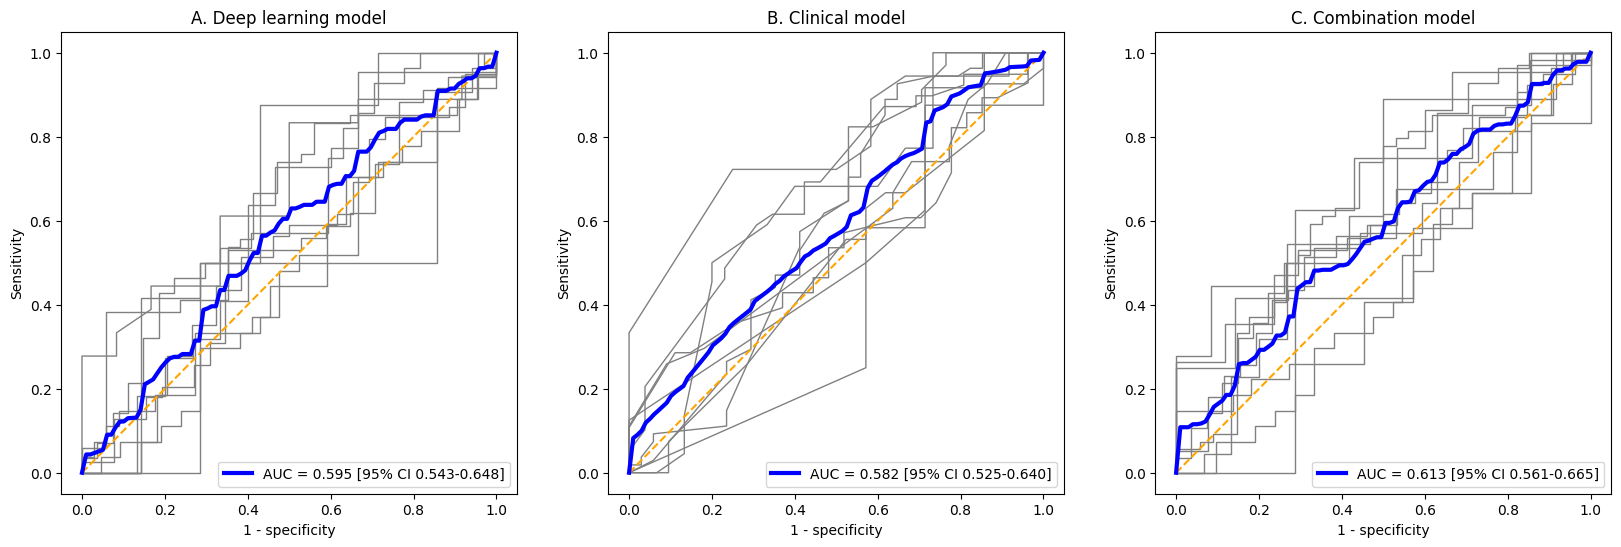

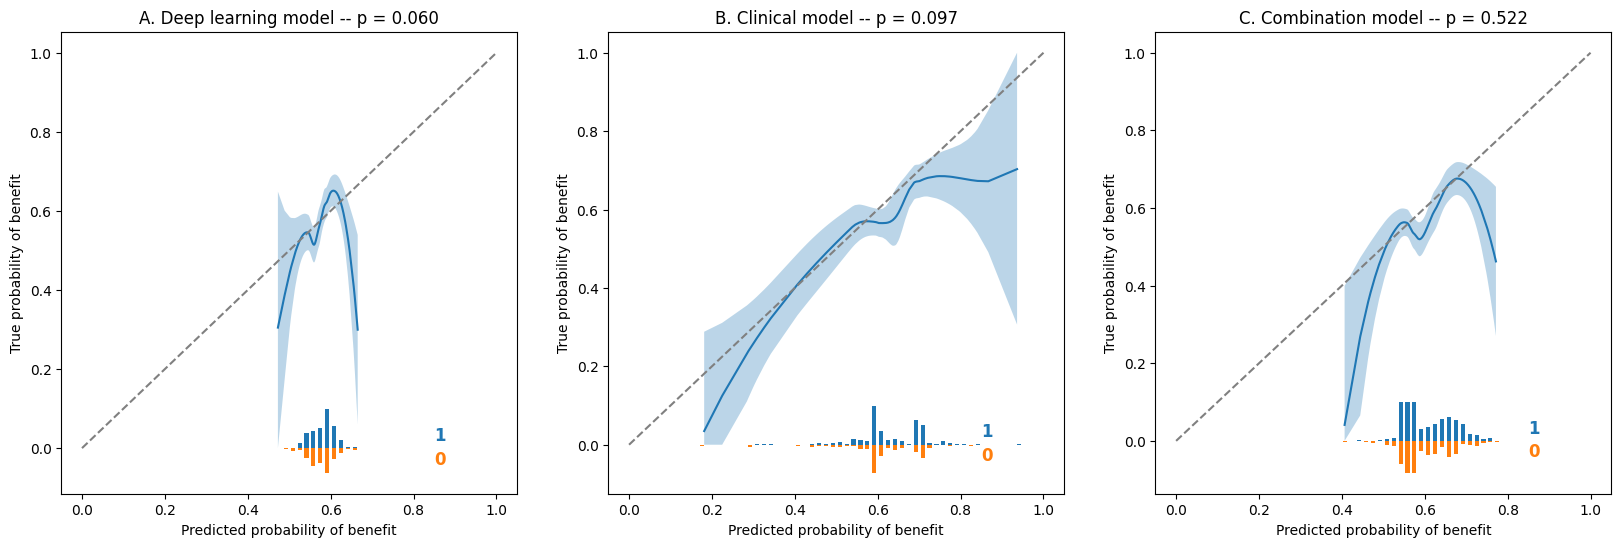

In [7]:
aucs = pd.read_csv('/home/rens/repos/premium_dl_ct/tables/auc_mono.csv').set_index('Unnamed: 0')
results = results.join(table1data.Therapy)
mono = results[results.Therapy == 'Anti-PD1']

fig, ax = plt.subplots(1,3, figsize=(20,6))
# deep learning model
aggregated_auc = (
    aucs.loc['cvAUC', 'calibrated_dl_preds'],
    aucs.loc['ci_lower', 'calibrated_dl_preds'],
    aucs.loc['ci_upper', 'calibrated_dl_preds'],
)
plot_roc('calibrated_dl_preds','dcb',mono, ax[0], aggregated_auc)
ax[0].set_title('A. Deep learning model')
# clinical model
aggregated_auc = (
    aucs.loc['cvAUC', 'clinical_preds'],
    aucs.loc['ci_lower', 'clinical_preds'],
    aucs.loc['ci_upper', 'clinical_preds'],
)
plot_roc('clinical_preds','dcb',mono, ax[1], aggregated_auc)
ax[1].set_title('B. Clinical model')
# combination model
aggregated_auc = (
    aucs.loc['cvAUC', 'combination_preds'],
    aucs.loc['ci_lower', 'combination_preds'],
    aucs.loc['ci_upper', 'combination_preds'],
)
plot_roc('combination_preds','dcb',mono, ax[2], aggregated_auc)
ax[2].set_title('C. Combination model')
fig.show()

fig, ax = plt.subplots(1,3, figsize=(20,6))
# deep learning model
plot_calibration_curve('calibrated_dl_preds','dcb',mono, ax[0])
p = aucs.loc['hoslem','calibrated_dl_preds']
ax[0].set_title(f'A. Deep learning model -- p = {p:.3f}')
# clinical model
plot_calibration_curve('clinical_preds','dcb',mono, ax[1])
p = aucs.loc['hoslem','clinical_preds']
ax[1].set_title(f'B. Clinical model -- p = {p:.3f}')
# ensemble model
plot_calibration_curve('combination_preds','dcb',mono, ax[2])
p = aucs.loc['hoslem','combination_preds']
ax[2].set_title(f'C. Combination model -- p = {p:.3f}')
fig.show()

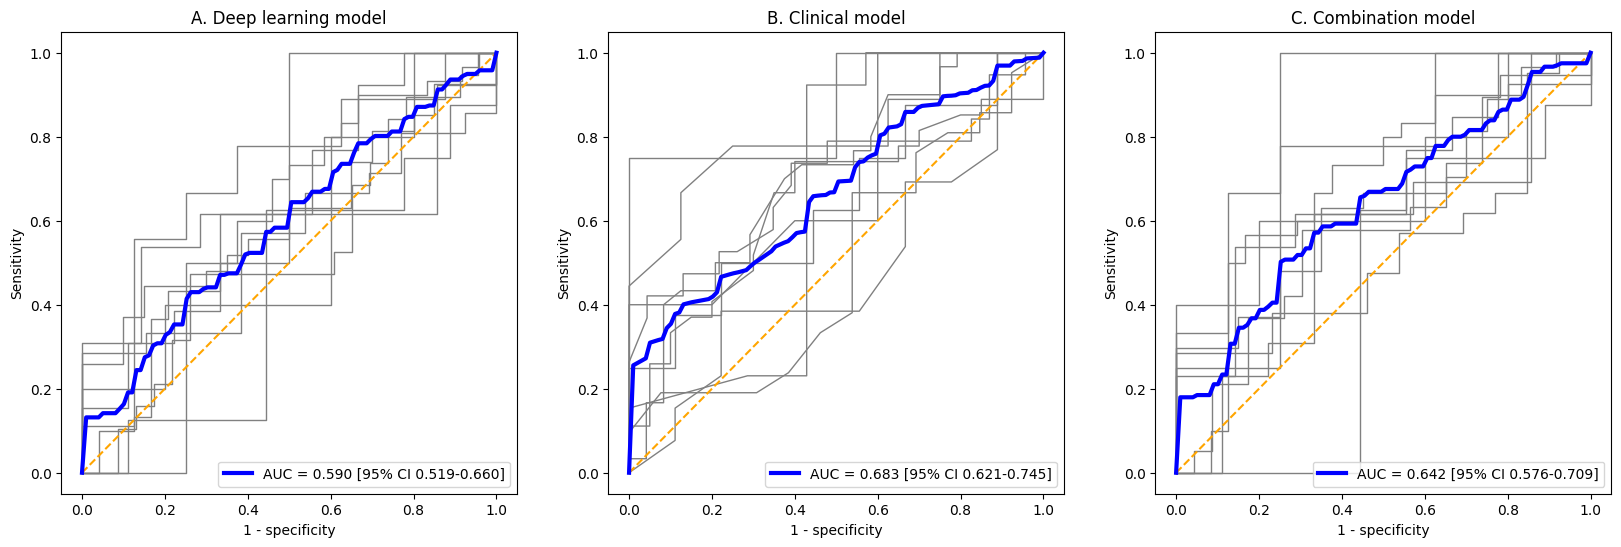

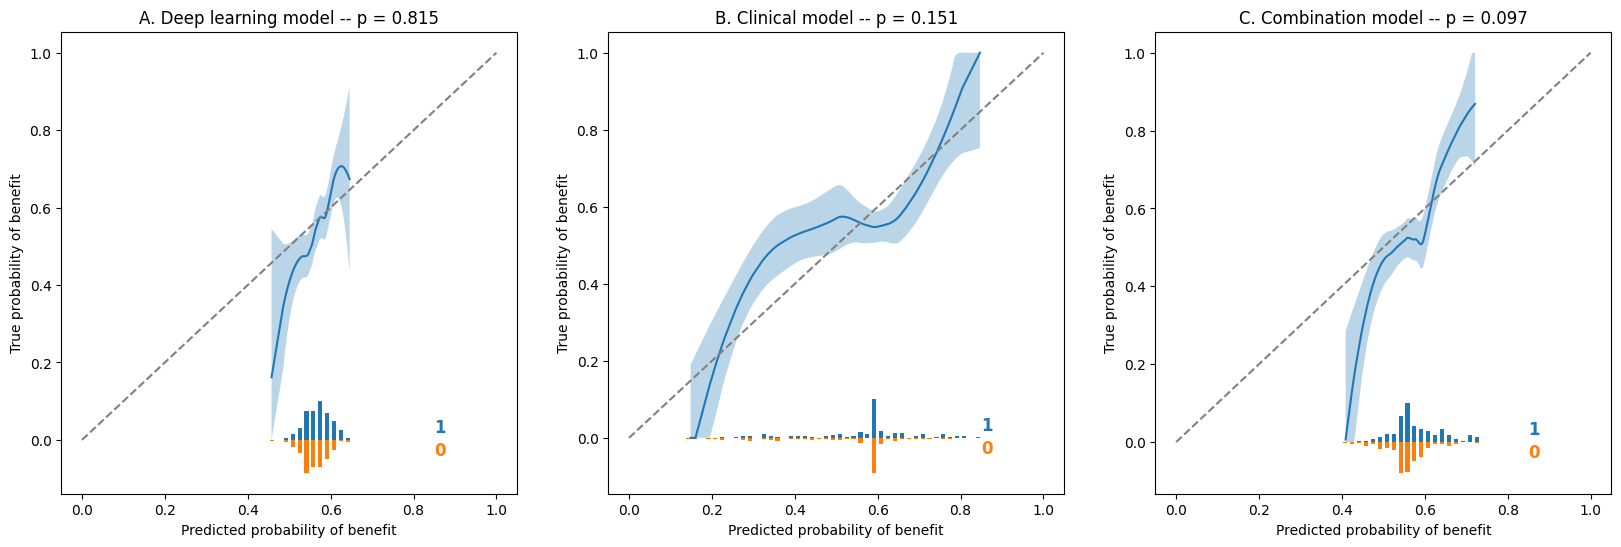

In [8]:
aucs = pd.read_csv('/home/rens/repos/premium_dl_ct/tables/auc_combi.csv').set_index('Unnamed: 0')
combi = results[results.Therapy == 'Ipilimumab & Nivolumab']

fig, ax = plt.subplots(1,3, figsize=(20,6))
# deep learning model
aggregated_auc = (
    aucs.loc['cvAUC', 'calibrated_dl_preds'],
    aucs.loc['ci_lower', 'calibrated_dl_preds'],
    aucs.loc['ci_upper', 'calibrated_dl_preds'],
)
plot_roc('calibrated_dl_preds','dcb',combi, ax[0], aggregated_auc)
ax[0].set_title('A. Deep learning model')
# clinical model
aggregated_auc = (
    aucs.loc['cvAUC', 'clinical_preds'],
    aucs.loc['ci_lower', 'clinical_preds'],
    aucs.loc['ci_upper', 'clinical_preds'],
)
plot_roc('clinical_preds','dcb',combi, ax[1], aggregated_auc)
ax[1].set_title('B. Clinical model')
# combination model
aggregated_auc = (
    aucs.loc['cvAUC', 'combination_preds'],
    aucs.loc['ci_lower', 'combination_preds'],
    aucs.loc['ci_upper', 'combination_preds'],
)
plot_roc('combination_preds','dcb',combi, ax[2], aggregated_auc)
ax[2].set_title('C. Combination model')
fig.show()

fig, ax = plt.subplots(1,3, figsize=(20,6))
# deep learning model
plot_calibration_curve('calibrated_dl_preds','dcb',combi, ax[0])
p = aucs.loc['hoslem','calibrated_dl_preds']
ax[0].set_title(f'A. Deep learning model -- p = {p:.3f}')
# clinical model
plot_calibration_curve('clinical_preds','dcb',combi, ax[1])
p = aucs.loc['hoslem','clinical_preds']
ax[1].set_title(f'B. Clinical model -- p = {p:.3f}')
# ensemble model
plot_calibration_curve('combination_preds','dcb',combi, ax[2])
p = aucs.loc['hoslem','combination_preds']
ax[2].set_title(f'C. Combination model -- p = {p:.3f}')
fig.show()

In [9]:
from sklearn.metrics import roc_auc_score

predictor1 = 'calibrated_dl_preds'
predictor2 = 'clinical_preds'

center_vs_auc = {}
center_vs_bootstraps = {}

def auc_diff(predictor1, predictor2, data):
    auc1 = roc_auc_score(data['dcb'], data[predictor1])
    auc2 = roc_auc_score(data['dcb'], data[predictor2])

    return auc1-auc2

for center in results.center.unique():
    subset = results[results.center == center]

    center_vs_auc[center] = auc_diff(predictor1, predictor2, subset)

    for n in range(1000):
        sample = subset.sample(len(subset), replace=True)
        break




In [20]:
import pandas as pd
from src.eval import TrainedModel, Config, get_fold_vs_run_ids
from src.data import DataModule
from src.config import radiomics_folder, lesion_level_labels_csv
import torch.nn as nn
from pathlib import Path
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


sweep_id = '8fki21ur'
fold_vs_id = get_fold_vs_run_ids(sweep_id)

test_center = 'vumc'
fold = 3

run_id = fold_vs_id[test_center][fold][1]
model = TrainedModel(run_id, '/dev/zero', fold)

class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
    
model.model.last_linear = Identity()
model.model.eval()

mock_wandb_config = Config(
    roi_selection_method='crop',
    dim = 3,
    size=182,
    roi_size=142,
    test_center=test_center,
    max_batch_size=6,
    inner_fold=0,
    lesion_target='lesion_benefit',
    sampler='vanilla',
    augmentation_noise_std=0.001
)

dm = DataModule(radiomics_folder, lesion_level_labels_csv, mock_wandb_config)
dm.setup()
dm.setup(stage='test')
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()



model.model.cuda()

df = pd.DataFrame(columns=[f'feature{f}' for f in range(2048)])

for dl in [train_dl, val_dl, test_dl]:
    for batch in dl:
        x = batch['img'].cuda()

        y_hat = model.model(x).cpu().detach().numpy()

        for ix, name in enumerate([Path(p).name for p in batch['img_meta_dict']['filename_or_obj']]):
            df.loc[name] = y_hat[ix].tolist()


lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';').set_index('lesion')

df = df.join(lesion_fu[['lesion_benefit', 'organ', 'patient']])
feature_columns = [f'feature{f}' for f in range(2048)]

tsne = TSNE(n_components=2)

tsne_results = tsne.fit_transform(df[feature_columns])

preds = preds.rename(columns={0:'Lesion level DL pred','level1_original_shape_MeshVolume':'Lesion volume'})
df= df.join(preds, on='patient')

/home/rens/repos/premium_dl_ct/src/eval.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.predictions = pd.Series(name=f"fold_{fold}")
Loading dataset: 100%|██████████| 465/465 [00:00<00:00, 1108784.17it/s]
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tab:orange
tab:blue
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:grey
tab:olive
r
b


KeyError: 'Lesion volume'

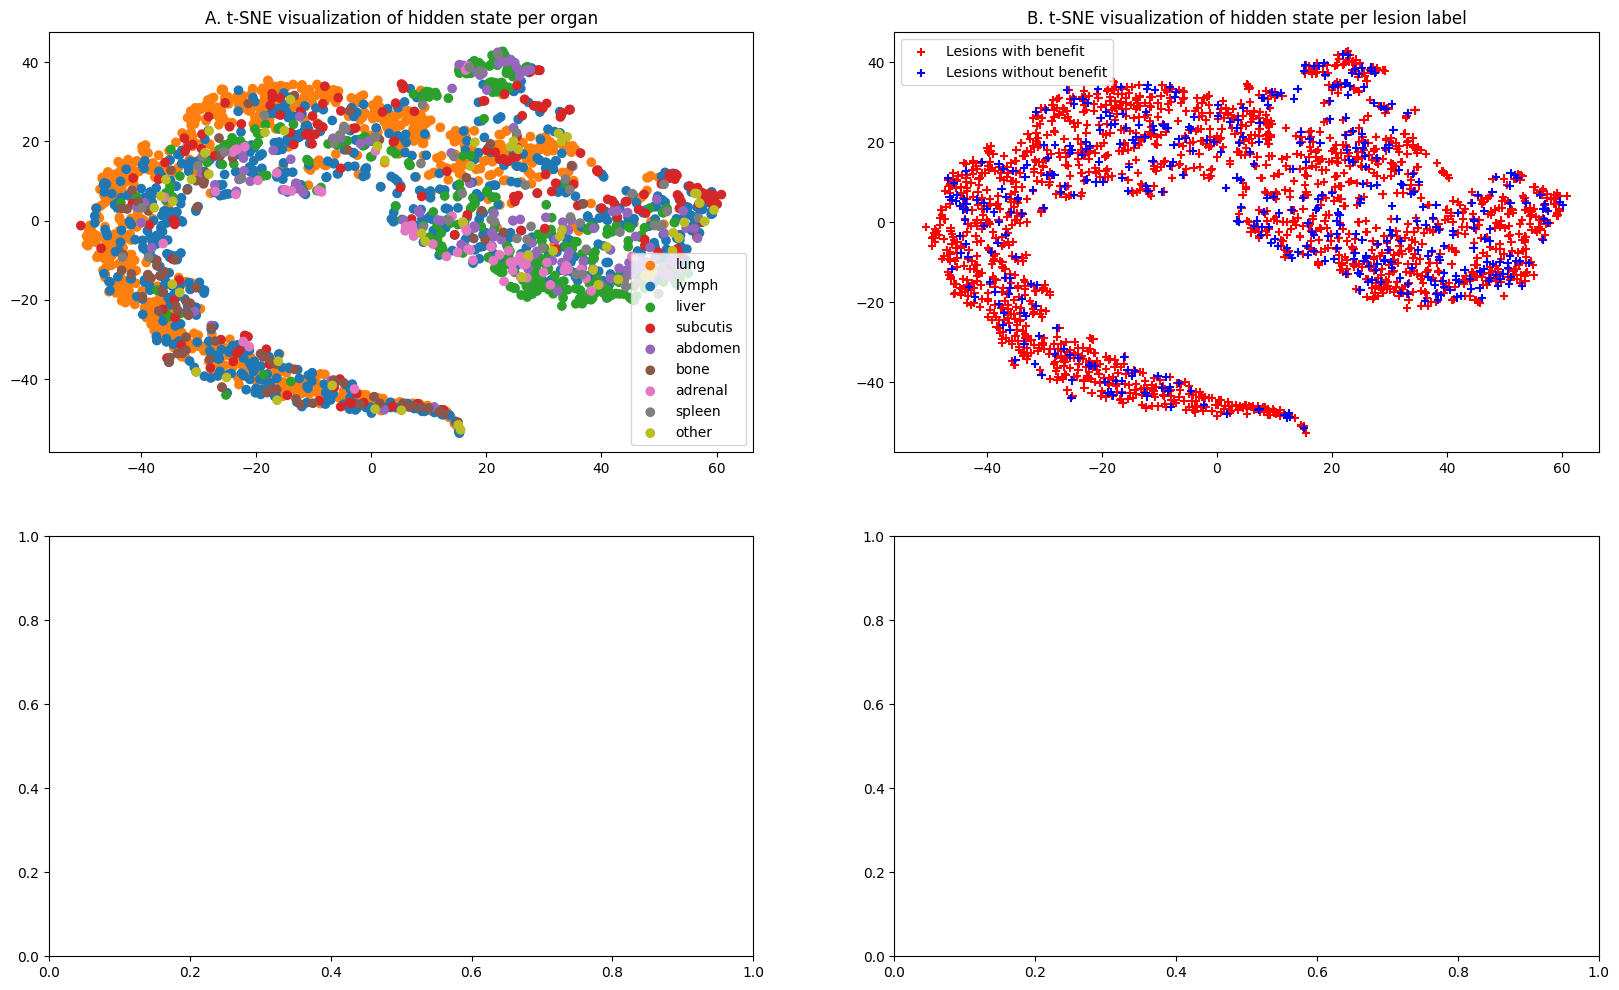

In [21]:
import numpy as np

fig, ax = plt.subplots(2,2, figsize=(20,12))

# organ
groupby = 'organ'
colors = {
    'lung':'tab:orange',
    'lymph':'tab:blue',
    'liver':'tab:green',
    'subcutis':'tab:red',
    'abdomen':'tab:purple',
    'bone':'tab:brown',
    'adrenal':'tab:pink',
    'spleen':'tab:grey',
    'other':'tab:olive'
}
for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    ax[0,0].scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{group}')
    ax[0,0].legend()
ax[0,0].set_title('A. t-SNE visualization of hidden state per organ')

# response
groupby = 'lesion_benefit'
colors = {
    1:'r',
    0:'b'
    
}

for group, color in colors.items():
    print(color)

    results = tsne_results[df[groupby] == group]
    if group == 1:
        label = 'Lesions with benefit'
    else:
        label = 'Lesions without benefit'
    ax[0,1].scatter(results[:,0], results[:,1], c=[color] * len(results), label=label, marker='+')
    ax[0,1].legend()
ax[0,1].set_title('B. t-SNE visualization of hidden state per lesion label')

# size
ax[1,0].scatter(tsne_results[:,0], tsne_results[:,1], c=np.log(df['Lesion volume']), cmap='seismic')
ax[1,0].set_title('C. t-SNE visualization of hidden state colored according to lesion size (red = larger)')

# prediction
ax[1,1].scatter(tsne_results[:,0], tsne_results[:,1], c=df['Lesion level DL pred'], cmap='seismic')
ax[1,1].set_title('D. t-SNE visualization of hidden state colored according to lesion prediction (red = higher)')



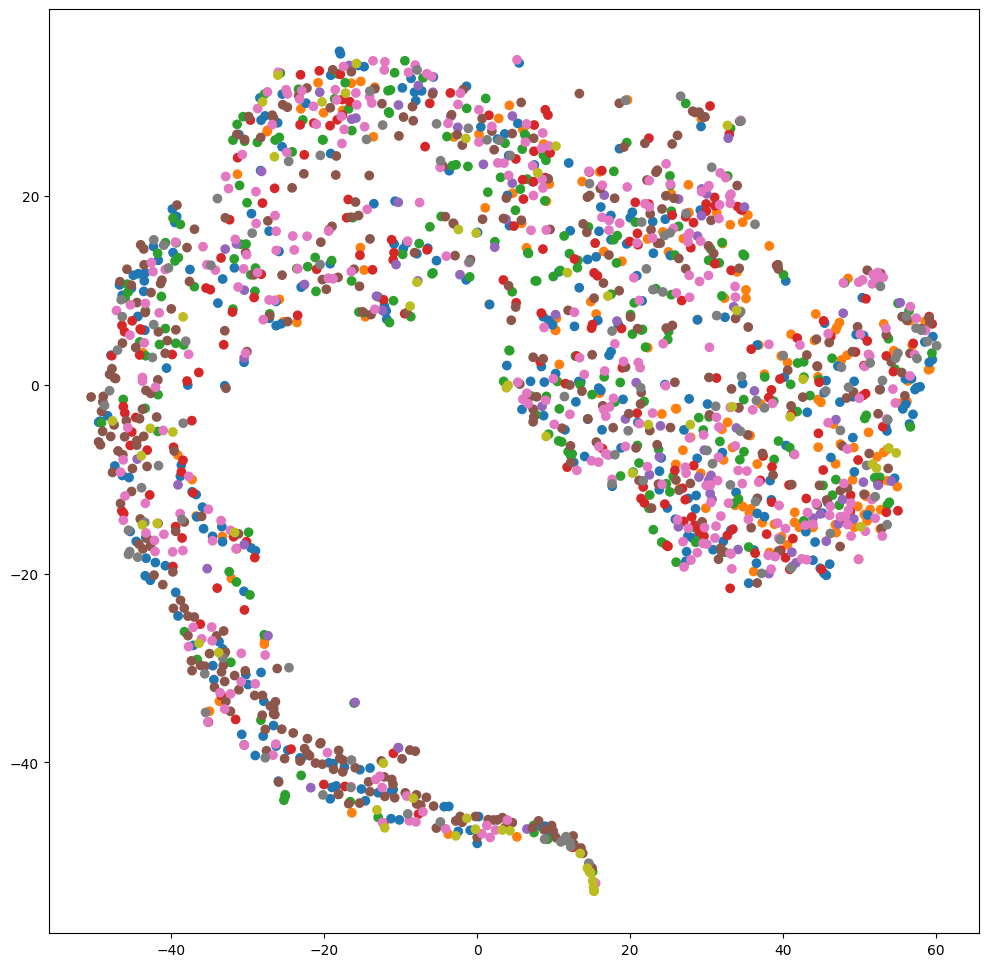

In [30]:
colors = {
    'amphia':'tab:orange',
    'isala':'tab:blue',
    'lumc':'tab:green',
    'maxima':'tab:red',
    'mst':'tab:purple',
    'umcg':'tab:brown',
    'umcu':'tab:pink',
    'zuyderland':'tab:grey',
    'radboud':'tab:olive',
    # 'vumc':'tab:cyan'
}

plt.figure(figsize=(12,12))
for group, color in colors.items():
    results = tsne_results[df['center'] == group]
    plt.scatter(results[:,0], results[:,1], c=[color] * len(results), label=f'{group}')

plt.show()

In [23]:
tsne_results.shape

(2300, 2)

In [27]:
df.center.unique()

array(['amphia', 'isala', 'lumc', 'maxima', 'mst', 'umcg', 'umcu',
       'zuyderland', 'radboud', 'vumc'], dtype=object)

In [ ]:


plt.scatter(tsne_results[:,0], tsne_results[:,1], c=np.log(df['Lesion volume']), cmap='seismic')

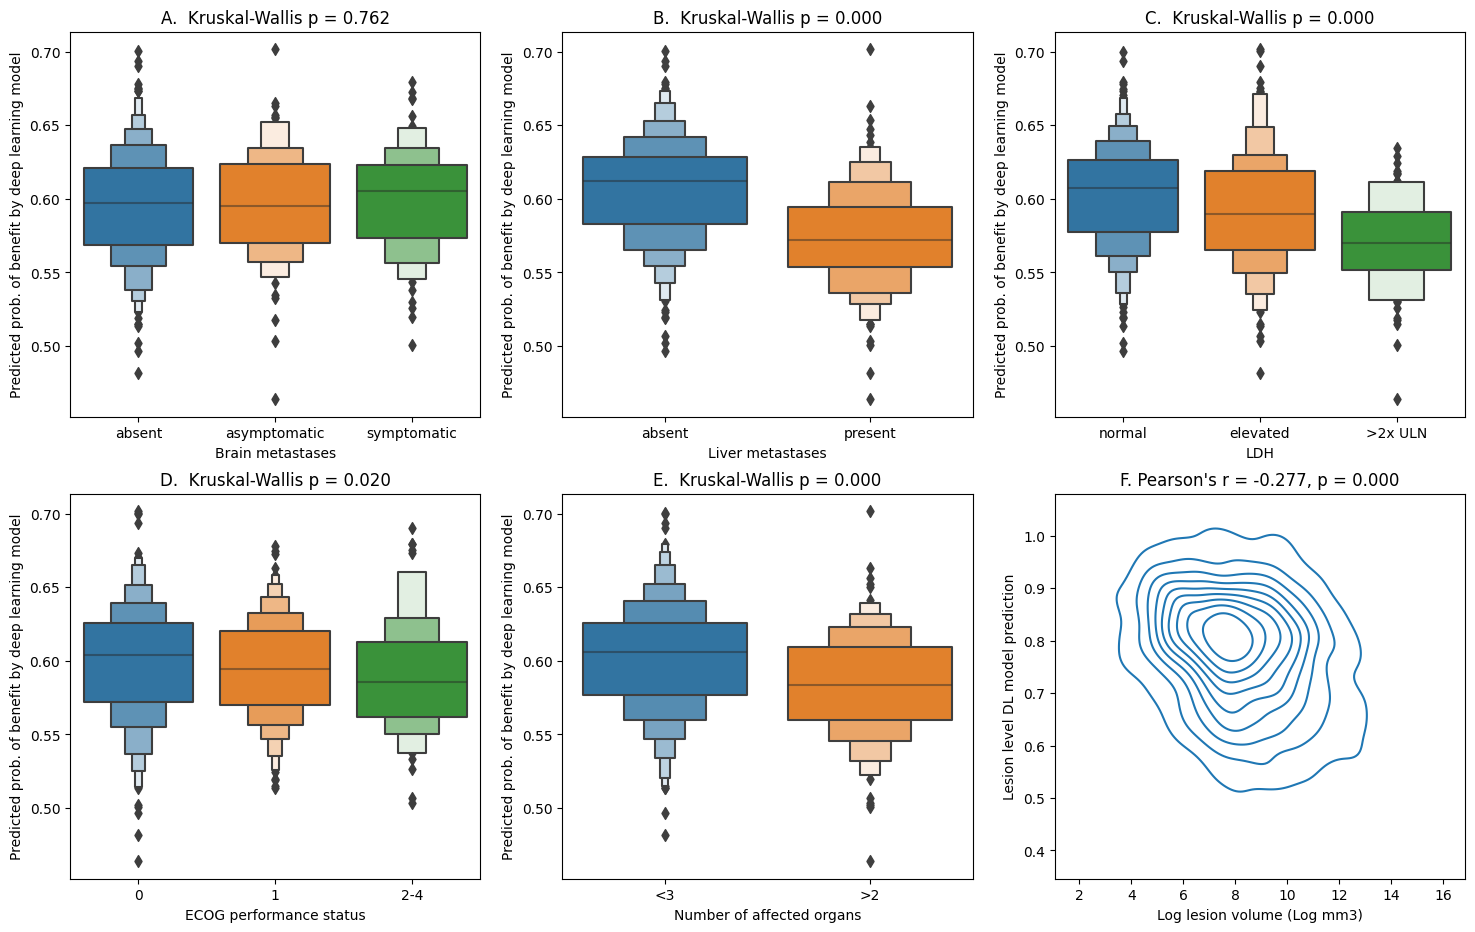

In [27]:
import numpy as np
import seaborn as sn
from scipy.stats import pearsonr
from src.plot_utils import plot_boxplot
from src.data import CENTERS

clinical_predictors = pd.read_csv('/mnt/c/Users/user/data/tables/clinical_predictors.csv').set_index('id')

clinical_predictors = clinical_predictors.rename(columns={
    'brain_metastasis':'Brain metastases',
    'locafmetlever':'Liver metastases',
    'WHO':'ECOG performance status',
    'no_affected_organs':'Number of affected organs'
})

clinical_variables = ['Brain metastases','Liver metastases','LDH','ECOG performance status','Number of affected organs']

order = {
    'Brain metastases':['absent','asymptomatic','symptomatic'],
    'Liver metastases':None,
    'LDH':None,
    'ECOG performance status':['0','1','2-4'],
    'Number of affected organs':None
}
letters = "ABCDEF"

fig, ax = plt.subplots(2,3, figsize=(18,11))
for ix in range(5):
    df = results.join(clinical_predictors[clinical_variables[ix]])
    df = df[df[clinical_variables[ix]] != 'missing']
    plot_boxplot(
        'calibrated_dl_preds',
        clinical_variables[ix],
        df, 
        ax=ax[ix // 3, ix % 3],
        order=order[clinical_variables[ix]]
    )
    ax[ix // 3, ix % 3].set_ylabel('Predicted prob. of benefit by deep learning model')
    ax[ix // 3, ix % 3].set_title(f"{letters[ix]}.  {ax[ix // 3, ix % 3].title._text}")

preds= []
for center in CENTERS:
    lesion_preds = pd.read_csv(save_folder / center / 'dl_test_preds.csv').set_index('Unnamed: 0')
    lesion_preds = lesion_preds[lesion_preds.isna().sum(axis=1) == 0]
    preds.append(lesion_preds)
preds = pd.concat(preds).mean(axis=1).to_frame()
radiomics = pd.read_csv('/mnt/c/Users/user/data/tables/radiomics_v4.csv').set_index('Unnamed: 0')
preds = preds.join(radiomics['level1_original_shape_MeshVolume'])

preds = preds.dropna()

x = np.log(preds['level1_original_shape_MeshVolume'].rename('Log lesion volume (Log mm3)'))
y = preds[0].rename('Lesion level DL model prediction')

sn.kdeplot(
    x=x, y=y, 
    ax=ax[1,2]
)

r, p = pearsonr(x, y)
ax[1,2].set_title(f'F. Pearson\'s r = {r:.3f}, p = {p:.3f}')

fig.show()

In [25]:
ax[0,0].title._text

'Kruskal-Wallis p = 0.762'